C:\Users\Art\AppData\Local\Temp\ipykernel_15048\288886426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample('H').mean()  # Resample to hourly data
C:\Users\Art\AppData\Local\Temp\ipykernel_15048\288886426.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')  # Forward fill missing values
C:\Users\Art\AppData\Local\Temp\ipykernel_15048\288886426.py:65: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_index = pd.date_range(start=df.index[-1] + pd.Timedelta(hours=1), periods=len(forecast_values), freq='H')


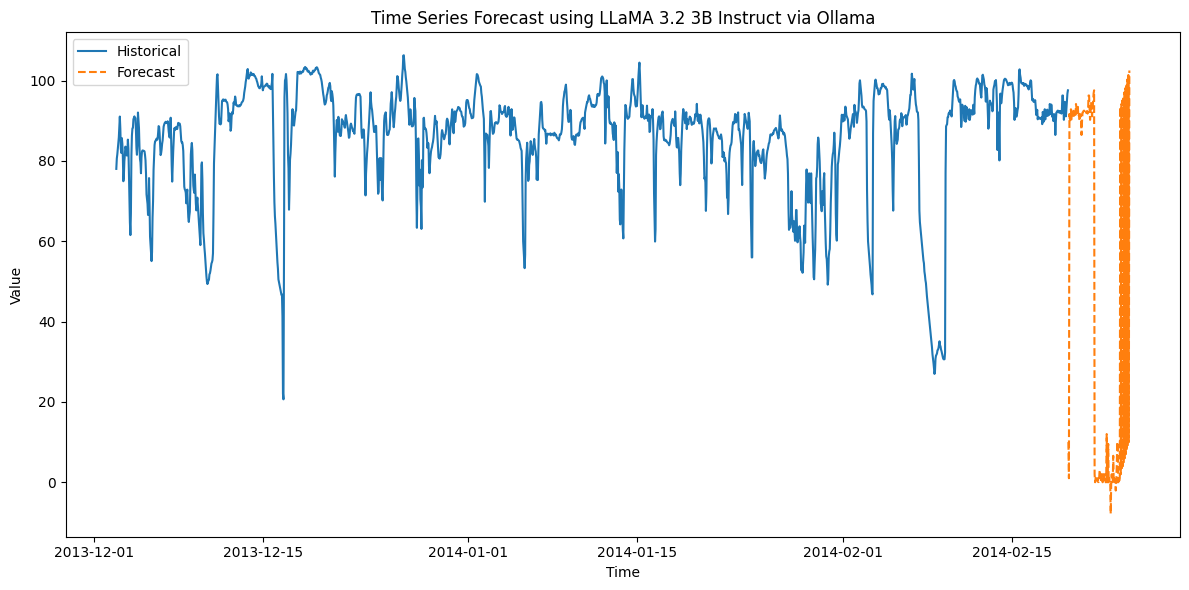

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import os

# Step 1: Download the dataset
dataset_url = "https://raw.githubusercontent.com/numenta/NAB/refs/heads/master/data/realKnownCause/machine_temperature_system_failure.csv"
dataset_path = "machine_temperature_system_failure.csv"

if not os.path.exists(dataset_path):
    print("Downloading dataset...")
    response = requests.get(dataset_url)
    with open(dataset_path, 'wb') as f:
        f.write(response.content)
    print("Dataset downloaded.")

# Step 2: Load and preprocess the dataset
df = pd.read_csv(dataset_path)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
df = df.sort_index()
df = df.resample('H').mean()  # Resample to hourly data
df = df.fillna(method='ffill')  # Forward fill missing values

# Step 3: Prepare the prompt for the LLaMA model
def prepare_prompt(series, forecast_horizon=10):
    recent_data = series[-50:].tolist()
    prompt = (
        "Given the following time series data:\n"
        f"{recent_data}\n"
        f"Please forecast the next {forecast_horizon} data points."
    )
    return prompt

# Step 4: Query the Ollama API
def query_ollama(prompt, model='llama3:instruct'):
    url = 'http://localhost:11434/api/generate'
    headers = {'Content-Type': 'application/json'}
    data = {
        'model': model,
        'prompt': prompt,
        'stream': False
    }
    response = requests.post(url, headers=headers, json=data)
    if response.status_code == 200:
        return response.json().get('response', '')
    else:
        raise Exception(f"Request failed with status code {response.status_code}: {response.text}")

# Step 5: Generate forecast
prompt = prepare_prompt(df['value'])
forecast_response = query_ollama(prompt)

# Step 6: Parse the forecasted values
import re

def parse_forecast(response_text):
    # Extract numbers from the response
    numbers = re.findall(r"[-+]?\d*\.\d+|\d+", response_text)
    return [float(num) for num in numbers]

forecast_values = parse_forecast(forecast_response)

# Step 7: Create forecast time index
forecast_index = pd.date_range(start=df.index[-1] + pd.Timedelta(hours=1), periods=len(forecast_values), freq='H')
forecast_series = pd.Series(forecast_values, index=forecast_index)

# Step 8: Plot the results
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['value'], label='Historical')
plt.plot(forecast_series.index, forecast_series, label='Forecast', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series Forecast using LLaMA 3 8B Instruct via Ollama')
plt.legend()
plt.tight_layout()
plt.show()
